In [ ]:
#Hello world
#To run the program just change the path of dataset and you are good to go
# use gpu or tpu runtime for faster compilation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error as mape


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

In [ ]:
# Enter the training data path
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data_covid.csv")

In [ ]:
# Enter the testing data path
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_data_covid.csv")

In [ ]:
# Last row of the train and test is common so remove the last row from train
data = data.iloc[:-1,:]
data

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,OxygenTanks,PopulationDensityPerSqKm
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1,8262,867
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1,9136,61
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2,3826,316
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3,9789,806
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3,882,369
...,...,...,...,...,...,...,...,...,...,...,...
14995,14996,2021-05-17,8:00 AM,Ladakh,-,-,14741,165,16452,5849,773
14996,14997,2021-05-17,8:00 AM,Lakshadweep,-,-,3633,14,4767,4046,490
14997,14998,2021-05-17,8:00 AM,Madhya Pradesh,-,-,629741,6992,731385,1195,595
14998,14999,2021-05-17,8:00 AM,Maharashtra,-,-,4826371,81486,5378452,9289,195


In [ ]:
# data preprocessing
data = data.drop(data[data["State/UnionTerritory"] == "Unassigned"].index)
data = data.drop(data[data["State/UnionTerritory"] == "Cases being reassigned to states"].index)
data = data.replace(to_replace = "Daman & Diu", value = "Dadra and Nagar Haveli and Daman and Diu")
data = data.replace(to_replace = "Telengana", value = "Telangana")
test_data = test_data.replace(to_replace = "Bihar****", value = "Bihar")
test_data = test_data.replace(to_replace = "Madhya Pradesh***", value = "Madhya Pradesh")
test_data = test_data.replace(to_replace = "Maharashtra***", value = "Maharashtra")
test_data = test_data.replace(to_replace = "Dadra and Nagar Haveli", value = "Dadra and Nagar Haveli and Daman and Diu")
test_data = test_data.replace(to_replace = "Karanataka", value = "Karnataka")
test_data = test_data.replace(to_replace = "Himanchal Pradesh", value = "Himachal Pradesh")

In [ ]:
# checking the no of unique states
len(test_data["State/UnionTerritory"].unique())

36

In [ ]:
len(data["State/UnionTerritory"].unique())

36

In [ ]:
#combine the train and test data
Total_data_prime = pd.concat([data[["Sno", "State/UnionTerritory", "Cured", "Confirmed"]],test_data[["Sno", "State/UnionTerritory", "Cured", "Confirmed"]]])

In [ ]:
# create a dictionary to store the state wise data
state_data_dict = {}

In [ ]:
# store the state wise data after normalizing it along with the scaler object

for state in Total_data_prime["State/UnionTerritory"].unique():
    sc2 = MinMaxScaler(feature_range=(0,1))
    sc1 = MinMaxScaler(feature_range=(0,1))
    df = Total_data_prime[Total_data_prime["State/UnionTerritory"] == state]
    death_df = data[data["State/UnionTerritory"] == state]
    df[["Cured", "Confirmed"]] = sc2.fit_transform(df[["Cured", "Confirmed"]].values)
    death_df[["Deaths"]] = sc1.fit_transform(death_df[["Deaths"]].values)
    state_data_dict[state] = [df, death_df, sc2, sc1]

In [ ]:
# fucntion to fit the data in a lstm model
def model_groupx(group1_train, death_df):
    x_train_scaled = group1_train[["Cured", "Confirmed"]].values
    y_train_scaled = death_df[["Deaths"]].values
    print(x_train_scaled.shape[0])
    print(y_train_scaled.shape)
    X_train_array = []
    y_train_array = []
    x = 4 # lag values is 4
    for i in range(x, x_train_scaled.shape[0]):
        X_train_array.append(x_train_scaled[i-x:i])
        y_train_array.append(y_train_scaled[i])

    X_train, y_train = np.array(X_train_array), np.array(y_train_array)
    X_train1 = X_train.reshape((X_train.shape[0], X_train.shape[1],2))
    print(X_train1.shape)
    #------------------------------------------------------------------------------------------
    early_stopping = EarlyStopping(monitor='loss', patience=10)

    model = Sequential([Bidirectional(layers.LSTM(44, return_sequences=True),input_shape=(x,2)),
                    layers.LSTM(8),
                    layers.Dense(16, activation = "relu"),
                    layers.Dense(1)])

    model.compile(optimizer=Adam(learning_rate = 0.001),loss='mae', metrics = ['mean_absolute_error', 'accuracy'] )
    model.fit(X_train1,y_train,epochs=200, batch_size=100, callbacks=[early_stopping], verbose=0)
    #loss_plot = pd.DataFrame(model.history.history)
    #loss_plot.plot()
    return model ,x

In [ ]:
# to predict and plot the graph
def to_predict(ai_model,X,Y,curr_state, scaler):
    p = ai_model.predict(X)
    m_deaths = scaler.inverse_transform(p)
    m_actual = scaler.inverse_transform(Y)
    plt.plot(m_deaths, color = "red")
    plt.plot(m_actual, color = "blue")
    plt.title(curr_state)
    plt.show()

In [ ]:
# creating the train and test data
def to_test(data_scaled, death_df, x):
    x_test_scaled = data_scaled[["Cured", "Confirmed"]].values
    y_train_scaled = death_df[["Deaths"]].values
    print(x_test_scaled.shape[0])
    #print(y_train_scaled.shape)
    X_test_array = []
    for i in range(x, x_test_scaled.shape[0]):
        X_test_array.append(x_test_scaled[i-x:i])

    X_test= np.array(X_test_array)
    print(X_test.shape)
    X_test1 = X_test.reshape((X_test.shape[0], X_test.shape[1],2))
    return X_test1, y_train_scaled

In [ ]:
# dictionary to store the fitted lstm model for each state
model_dict = {}

324
(324, 1)
(320, 4, 2)
410
(406, 4, 2)
13/13 [==============================] - 1s 3ms/step


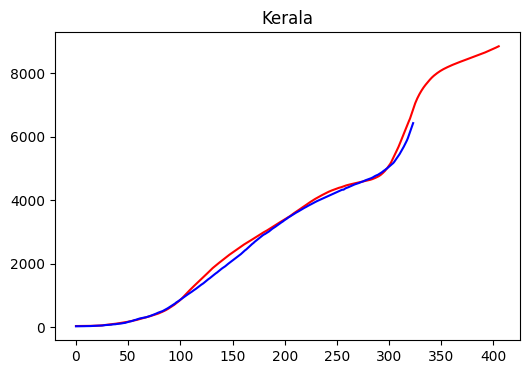

291
(291, 1)
(287, 4, 2)
378
(374, 4, 2)
12/12 [==============================] - 1s 3ms/step


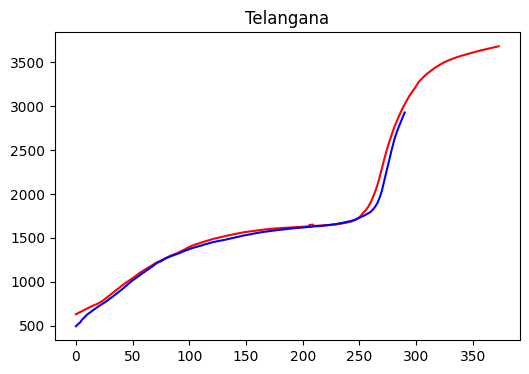

142
(142, 1)
(138, 4, 2)
228
(224, 4, 2)
7/7 [==============================] - 1s 4ms/step


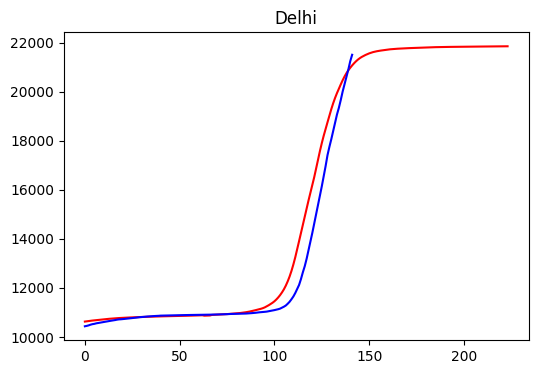

290
(290, 1)
(286, 4, 2)
377
(373, 4, 2)
12/12 [==============================] - 1s 3ms/step


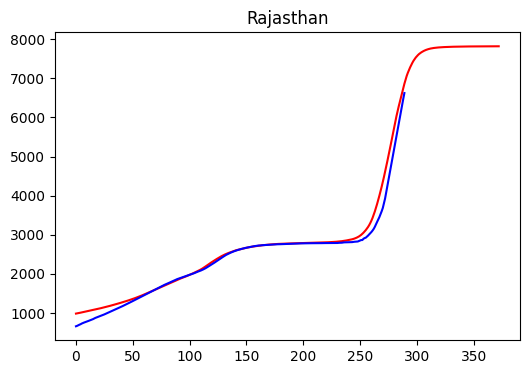

139
(139, 1)
(135, 4, 2)
226
(222, 4, 2)
7/7 [==============================] - 1s 4ms/step


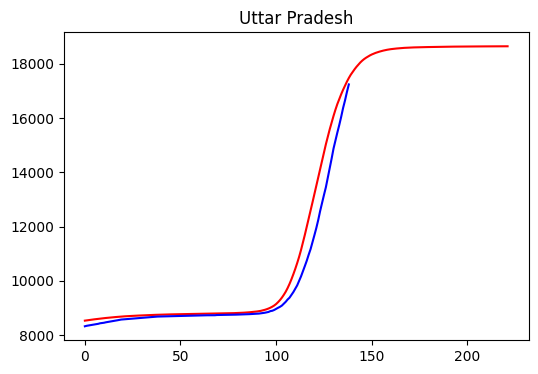

290
(290, 1)
(286, 4, 2)
376
(372, 4, 2)
12/12 [==============================] - 1s 4ms/step


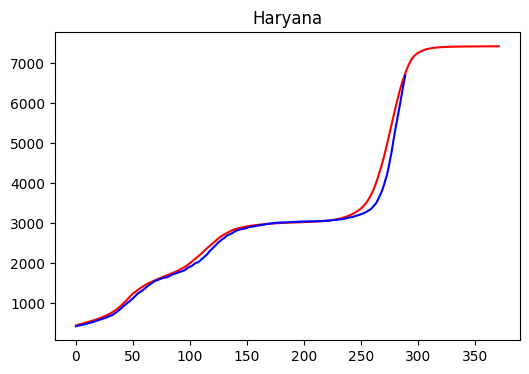

287
(287, 1)
(283, 4, 2)
373
(369, 4, 2)
12/12 [==============================] - 1s 3ms/step


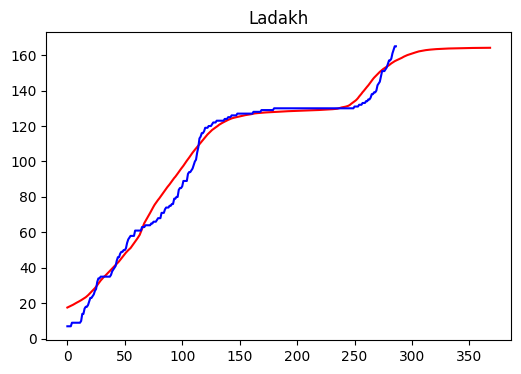

286
(286, 1)
(282, 4, 2)
373
(369, 4, 2)
12/12 [==============================] - 2s 5ms/step


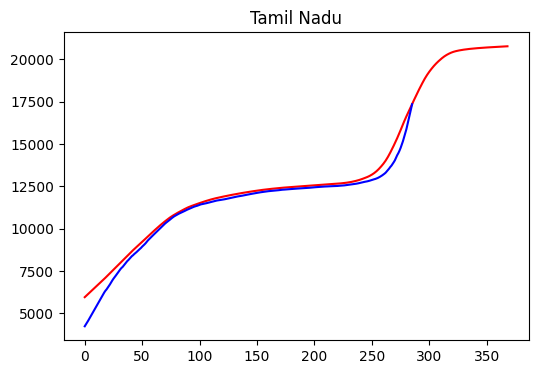

285
(285, 1)
(281, 4, 2)
371
(367, 4, 2)
12/12 [==============================] - 2s 6ms/step


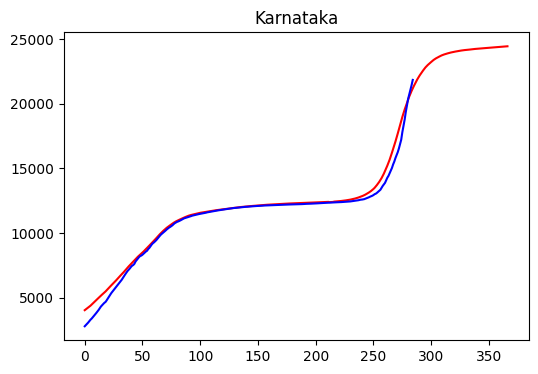

135
(135, 1)
(131, 4, 2)
221
(217, 4, 2)
7/7 [==============================] - 1s 4ms/step


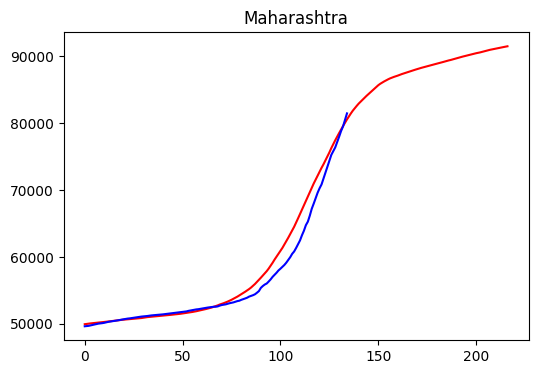

134
(134, 1)
(130, 4, 2)
221
(217, 4, 2)
7/7 [==============================] - 1s 4ms/step


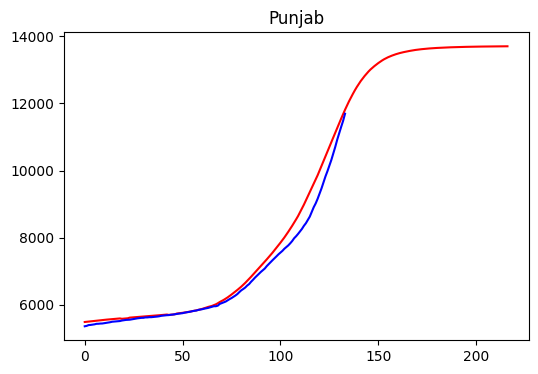

285
(285, 1)
(281, 4, 2)
371
(367, 4, 2)
12/12 [==============================] - 1s 4ms/step


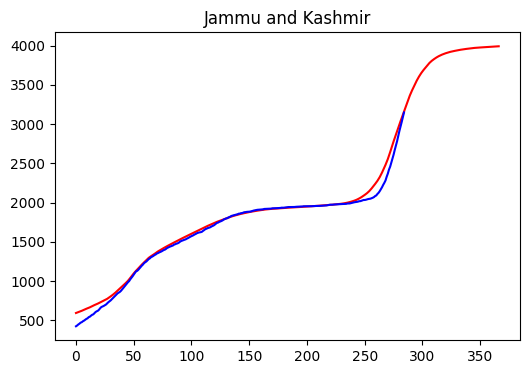

282
(282, 1)
(278, 4, 2)
368
(364, 4, 2)
12/12 [==============================] - 1s 4ms/step


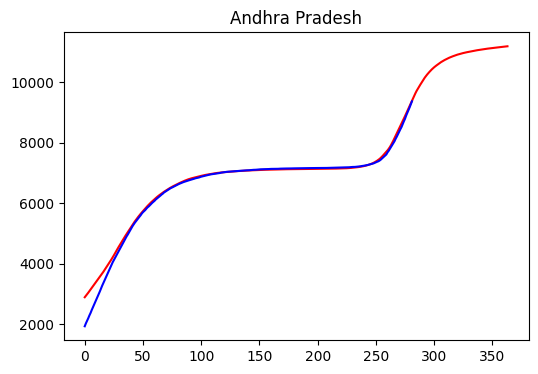

278
(278, 1)
(274, 4, 2)
365
(361, 4, 2)
12/12 [==============================] - 1s 3ms/step


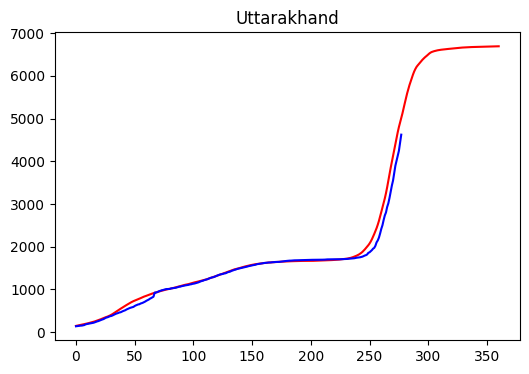

277
(277, 1)
(273, 4, 2)
364
(360, 4, 2)
12/12 [==============================] - 1s 4ms/step


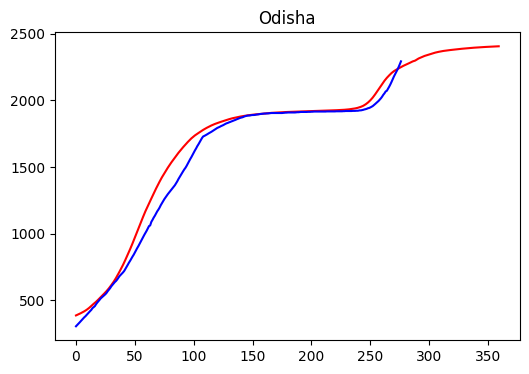

275
(275, 1)
(271, 4, 2)
362
(358, 4, 2)
12/12 [==============================] - 1s 4ms/step


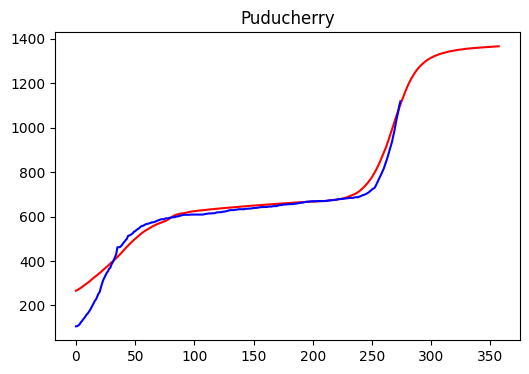

275
(275, 1)
(271, 4, 2)
362
(358, 4, 2)
12/12 [==============================] - 1s 6ms/step


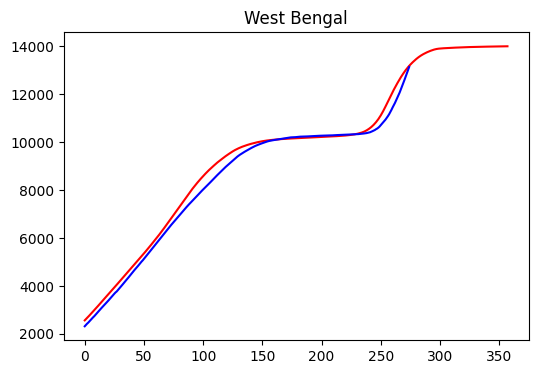

275
(275, 1)
(271, 4, 2)
361
(357, 4, 2)
12/12 [==============================] - 1s 5ms/step


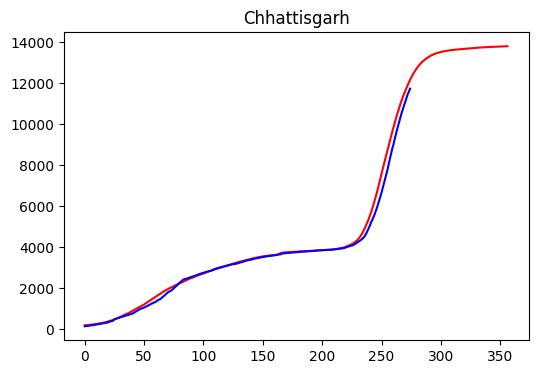

125
(125, 1)
(121, 4, 2)
211
(207, 4, 2)
7/7 [==============================] - 1s 5ms/step


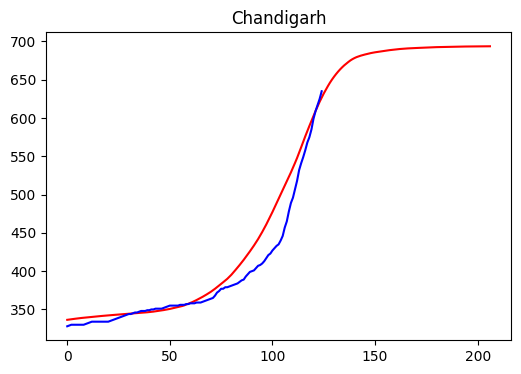

124
(124, 1)
(120, 4, 2)
210
(206, 4, 2)
7/7 [==============================] - 2s 5ms/step


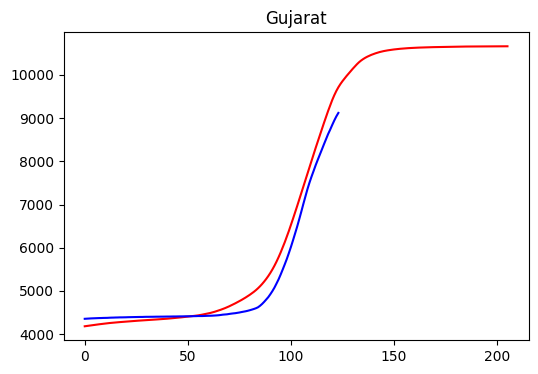

273
(273, 1)
(269, 4, 2)
359
(355, 4, 2)
12/12 [==============================] - 1s 4ms/step


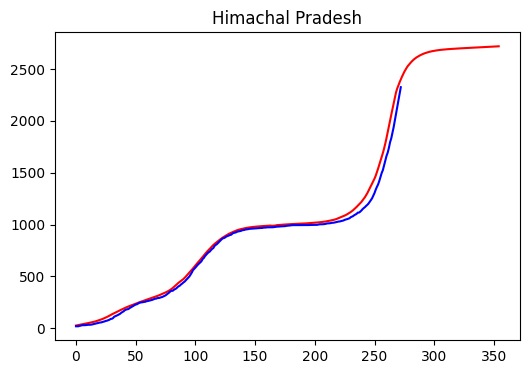

123
(123, 1)
(119, 4, 2)
209
(205, 4, 2)
7/7 [==============================] - 1s 6ms/step


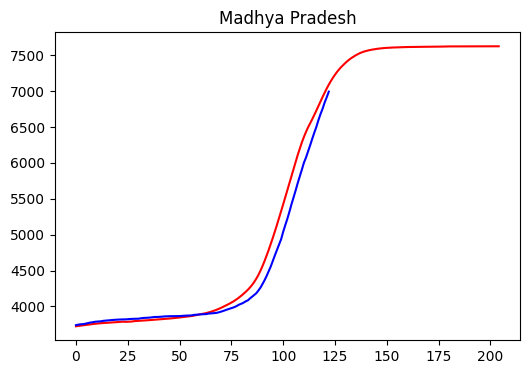

272
(272, 1)
(268, 4, 2)
358
(354, 4, 2)
12/12 [==============================] - 1s 4ms/step


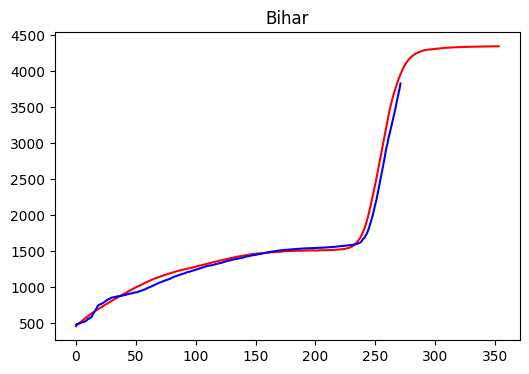

270
(270, 1)
(266, 4, 2)
356
(352, 4, 2)
11/11 [==============================] - 1s 4ms/step


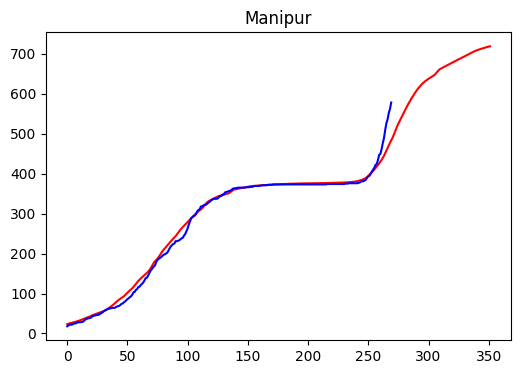

268
(268, 1)
(264, 4, 2)
355
(351, 4, 2)
11/11 [==============================] - 2s 4ms/step


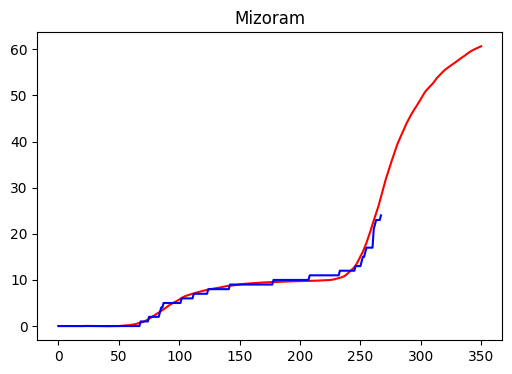

268
(268, 1)
(264, 4, 2)
354
(350, 4, 2)
11/11 [==============================] - 1s 5ms/step


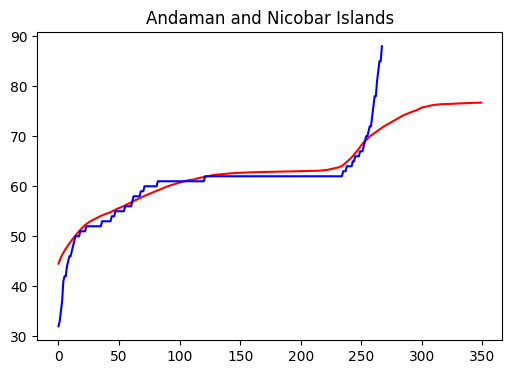

268
(268, 1)
(264, 4, 2)
354
(350, 4, 2)
11/11 [==============================] - 1s 4ms/step


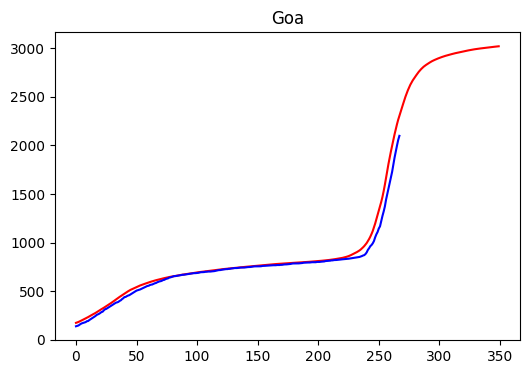

262
(262, 1)
(258, 4, 2)
348
(344, 4, 2)
11/11 [==============================] - 1s 4ms/step


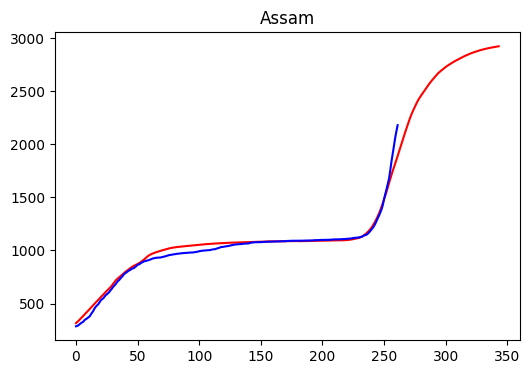

262
(262, 1)
(258, 4, 2)
348
(344, 4, 2)
11/11 [==============================] - 1s 4ms/step


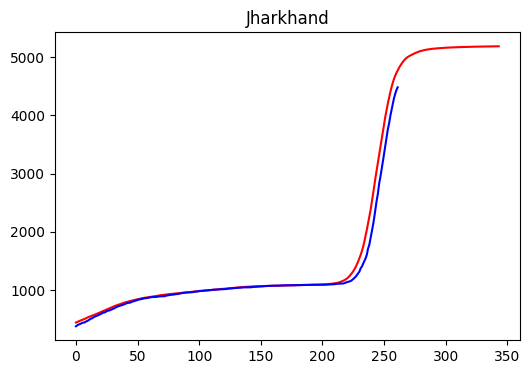

260
(260, 1)
(256, 4, 2)
346
(342, 4, 2)
11/11 [==============================] - 1s 4ms/step


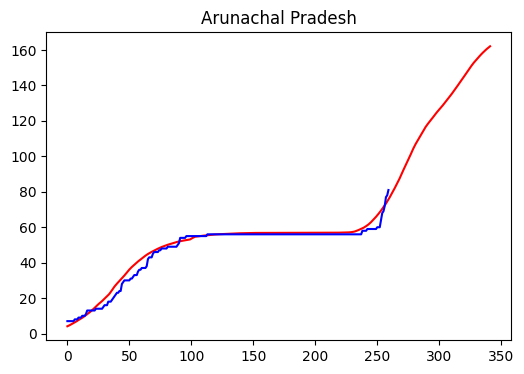

255
(255, 1)
(251, 4, 2)
342
(338, 4, 2)
11/11 [==============================] - 1s 4ms/step


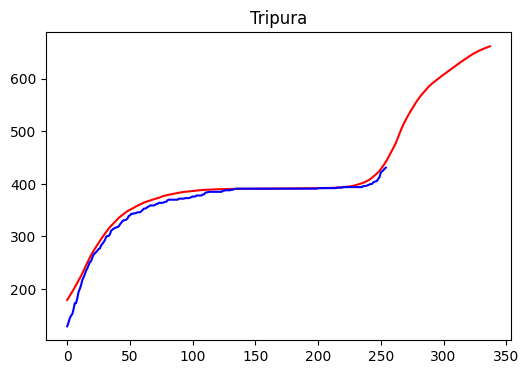

215
(215, 1)
(211, 4, 2)
302
(298, 4, 2)
10/10 [==============================] - 1s 4ms/step


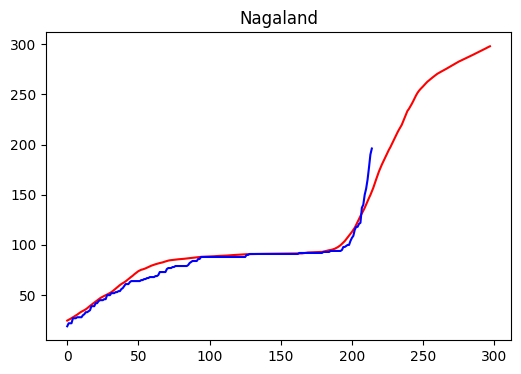

248
(248, 1)
(244, 4, 2)
335
(331, 4, 2)
11/11 [==============================] - 1s 4ms/step


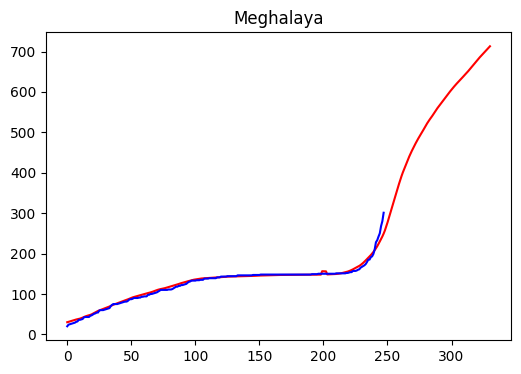

228
(228, 1)
(224, 4, 2)
314
(310, 4, 2)
10/10 [==============================] - 1s 4ms/step


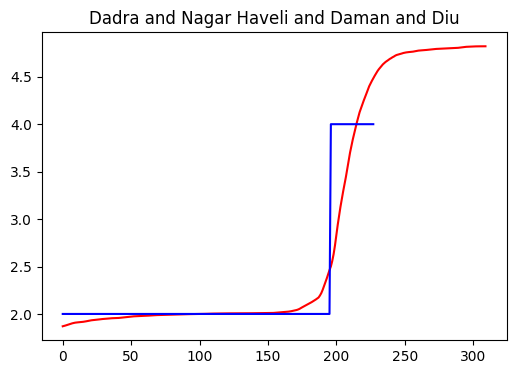

208
(208, 1)
(204, 4, 2)


In [ ]:
# for each state run the lstm model and store it in the dictionary
for state in state_data_dict:
    # few states works better when first 300(or less) days where neglected
    if state in ["Maharashtra", "Delhi", "Uttar Pradesh", "Punjab", "Chandigarh", "Gujarat", "Madhya Pradesh"]:
        death_x = state_data_dict[state][1].iloc[300:,:]
        df_x = state_data_dict[state][0].iloc[300:,:]
        #print(df_x)
        scaler = state_data_dict[state][3]
        data_scaled = df_x.iloc[:len(death_x),:]
        m1, v = model_groupx(data_scaled, death_x)
        model_dict[state] = [m1, v]
        X, Y = to_test(df_x, death_x, v)
        to_predict(m1, X, Y, state, scaler)
    else:
        death_x = state_data_dict[state][1].iloc[150:,:]
        df_x = state_data_dict[state][0].iloc[150:,:]
        #print(df_x)
        scaler = state_data_dict[state][3]
        data_scaled = df_x.iloc[:len(death_x),:]
        m1, v = model_groupx(data_scaled, death_x)
        model_dict[state] = [m1, v]
        X, Y = to_test(df_x, death_x, v)
        to_predict(m1, X, Y, state, scaler)

In [ ]:
# create a new dataframe to store the output
output_df = pd.DataFrame(Total_data_prime["Sno"])

In [ ]:
output_df

,Sno
0,1
1,2
2,3
3,4
4,5
...,...
3105,18106
3106,18107
3107,18108
3108,18109


In [ ]:
output_df["Deaths"] = None

In [ ]:
len(model_dict)

36

In [ ]:
# for each state predict the death and store it in the output dataframe
for unique_state in model_dict:
    print(unique_state)
    curr = state_data_dict[unique_state][0]
    inputs = curr[["Cured", "Confirmed"]].values
    X_test = []
    #print(inputs.shape, d[unique_state][1])
    length = model_dict[unique_state][1]
    for i in range(length, inputs.shape[0]):
        X_test.append(inputs[i - length : i])
    #print(X_test[0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],2))
    #print(X_test.shape)
    predicted_deaths = model_dict[unique_state][0].predict(X_test)
    #print(predicted_deaths.shape)
    predicted_deaths = state_data_dict[unique_state][3].inverse_transform(predicted_deaths)
    item = 0
    print(len(curr["Sno"]), predicted_deaths.shape[0],length)
    # iterate through the sno and store the respective predicted death
    for s in curr["Sno"]:
        if length == 0:
            output_df.loc[(output_df["Sno"] == s),"Deaths"] = predicted_deaths[item]
            item += 1
        else:
            length -= 1

Kerala
18/18 [==============================] - 0s 4ms/step
560 555 5
Telangana
17/17 [==============================] - 0s 5ms/step
528 523 5
Delhi
17/17 [==============================] - 0s 4ms/step
528 523 5
Rajasthan
17/17 [==============================] - 0s 4ms/step
527 522 5
Uttar Pradesh
17/17 [==============================] - 0s 4ms/step
526 521 5
Haryana
17/17 [==============================] - 0s 4ms/step
526 521 5
Ladakh
17/17 [==============================] - 0s 7ms/step
523 518 5
Tamil Nadu
17/17 [==============================] - 0s 6ms/step
523 518 5
Karnataka
17/17 [==============================] - 0s 7ms/step
521 516 5
Maharashtra
17/17 [==============================] - 0s 6ms/step
521 516 5
Punjab
17/17 [==============================] - 0s 7ms/step
521 516 5
Jammu and Kashmir
17/17 [==============================] - 0s 7ms/step
521 516 5
Andhra Pradesh
17/17 [==============================] - 0s 7ms/step
518 513 5
Uttarakhand
16/16 [===========================

In [ ]:
iitmop11 = output_df.iloc[-3110:,:]

In [ ]:
iitmop11

,Sno,Deaths
0,15001,218.54422
1,15002,26.616241
2,15003,124.951187
3,15004,2918.808594
4,15005,1104.373169
...,...,...
3105,18106,3639.573242
3106,18107,734.385803
3107,18108,6756.585449
3108,18109,18505.0


In [ ]:
iitmop11.to_csv("IITM_Shastra_op11.csv", index=False)

In [ ]:
Total_data_prime

,Sno,State/UnionTerritory,Cured,Confirmed
0,1,Kerala,0,1
1,2,Kerala,0,1
2,3,Kerala,0,2
3,4,Kerala,0,3
4,5,Kerala,0,3
...,...,...,...,...
3105,18106,Telangana,638410,650353
3106,18107,Tripura,77811,80660
3107,18108,Uttarakhand,334650,342462
3108,18109,Uttar Pradesh,1685492,1708812


Kerala


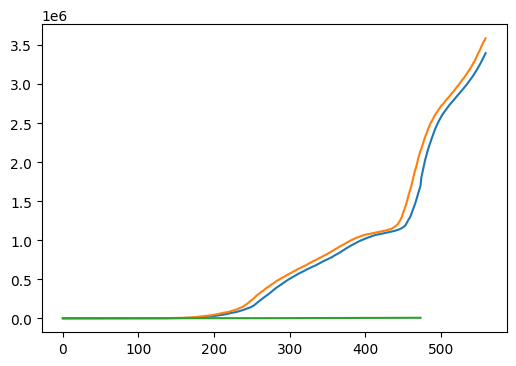

Telangana


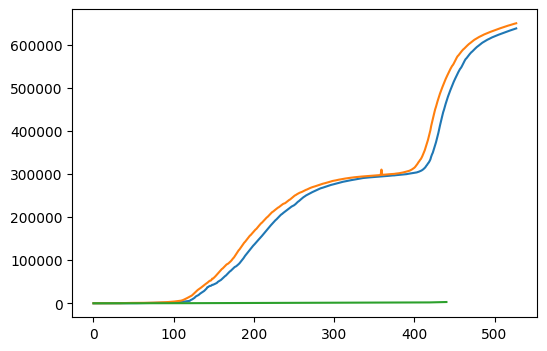

Delhi


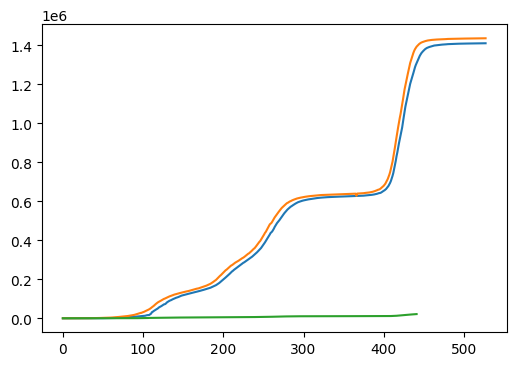

Rajasthan


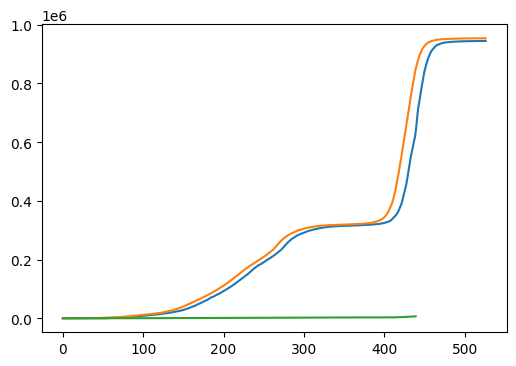

Uttar Pradesh


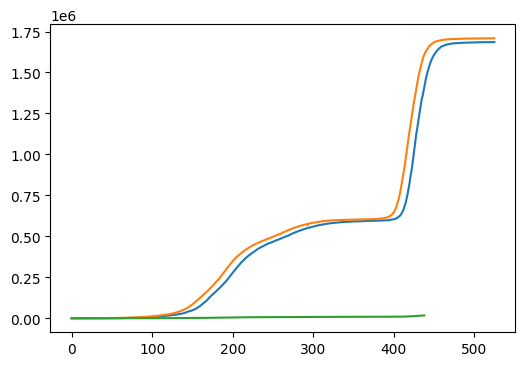

Haryana


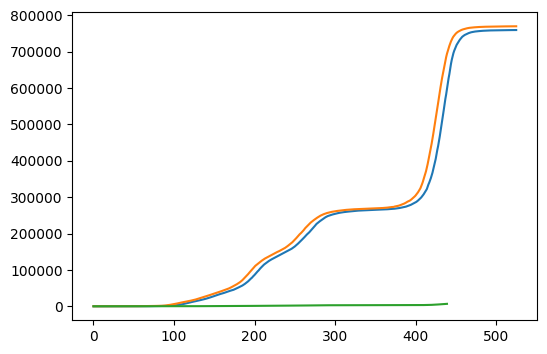

Ladakh


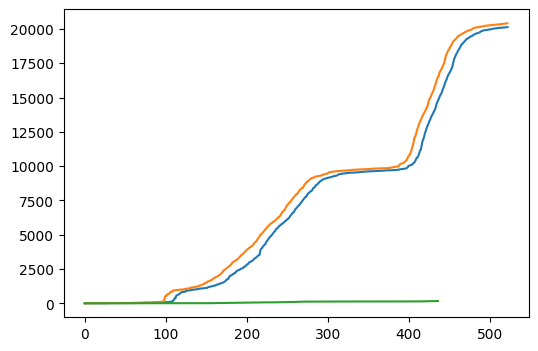

Tamil Nadu


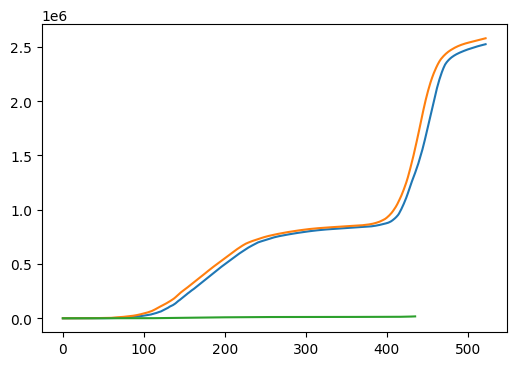

Karnataka


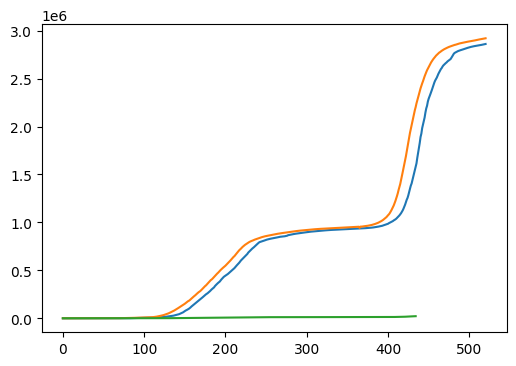

Maharashtra


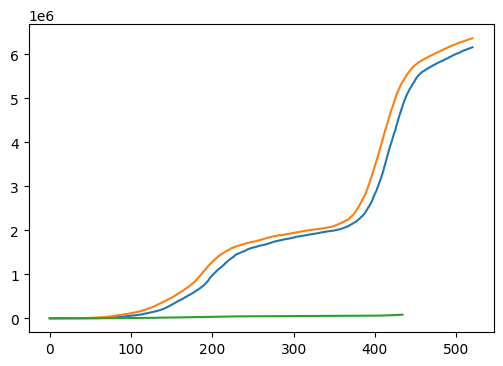

Punjab


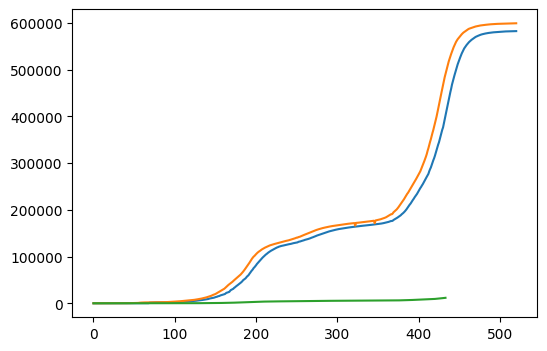

Jammu and Kashmir


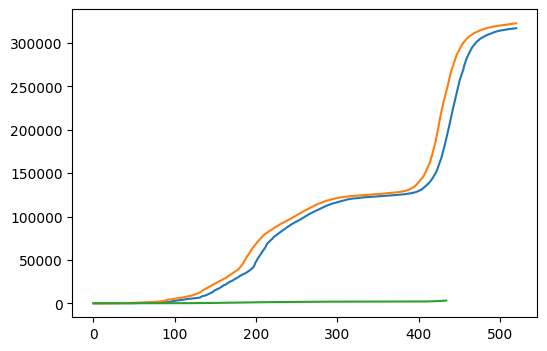

Andhra Pradesh


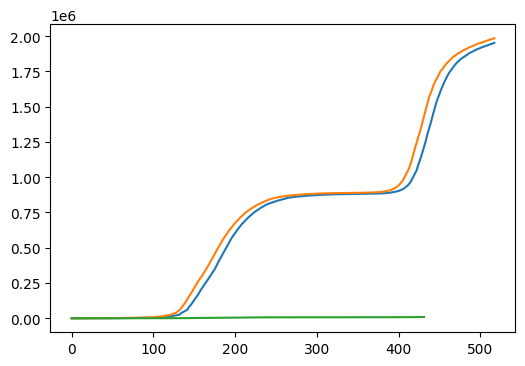

Uttarakhand


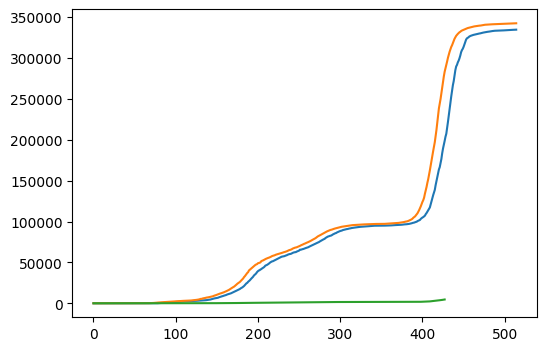

Odisha


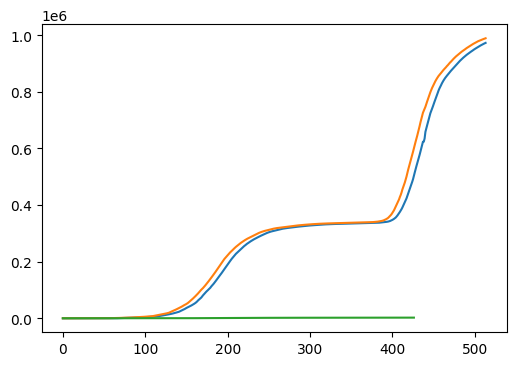

Puducherry


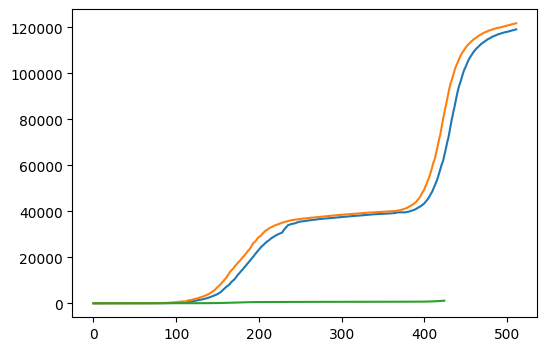

West Bengal


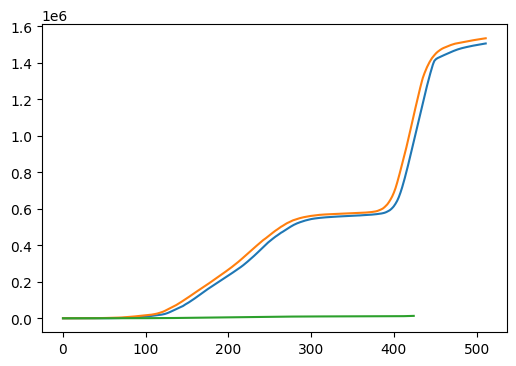

Chhattisgarh


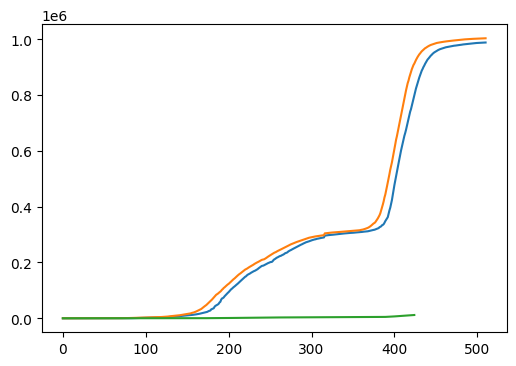

Chandigarh


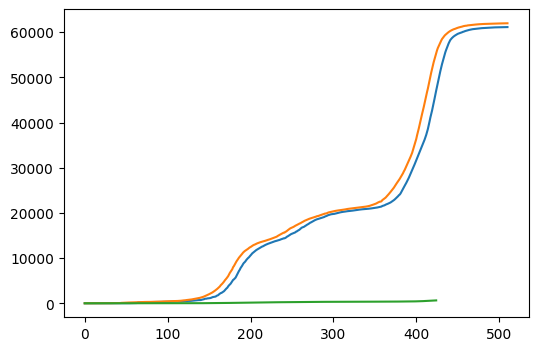

Gujarat


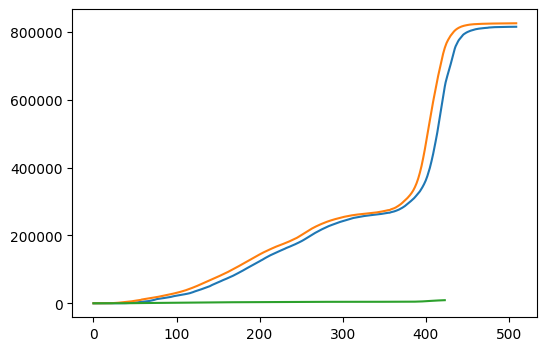

Himachal Pradesh


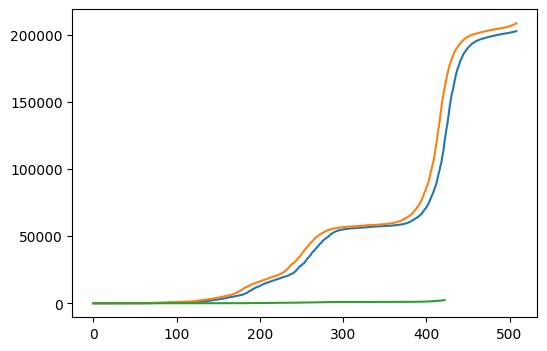

Madhya Pradesh


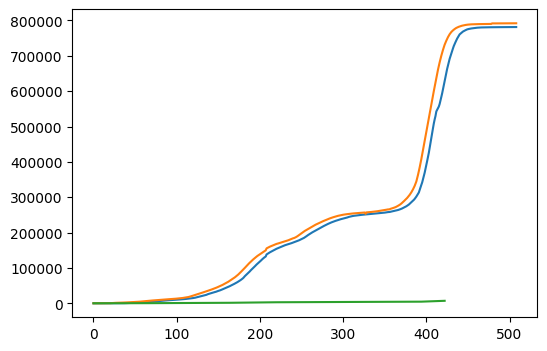

Bihar


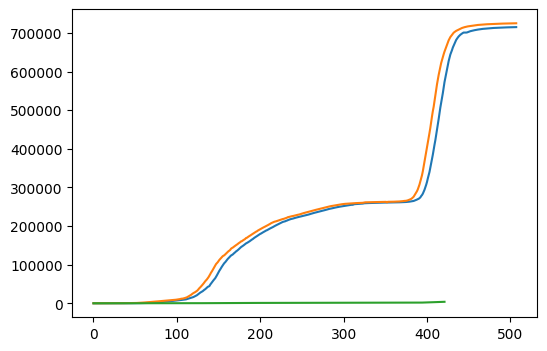

Manipur


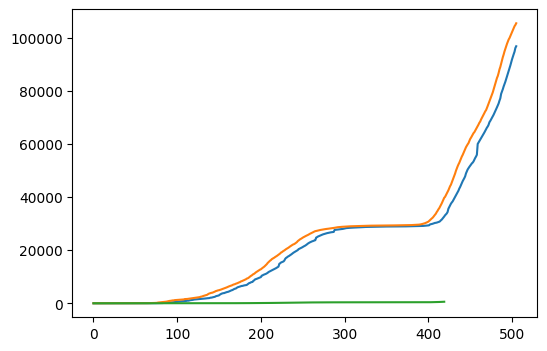

Mizoram


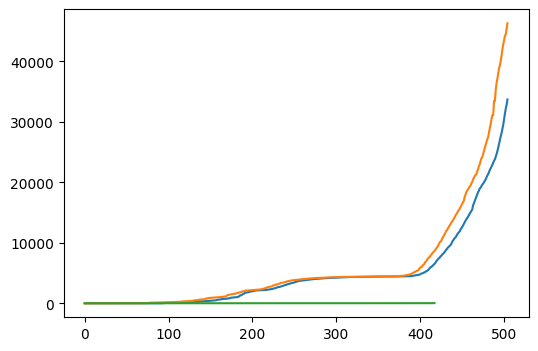

Andaman and Nicobar Islands


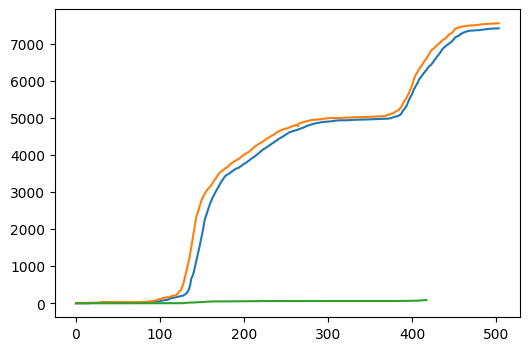

Goa


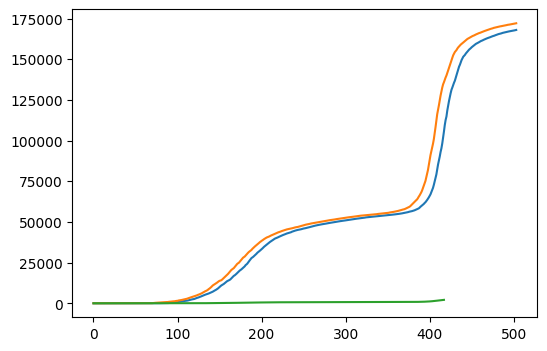

Assam


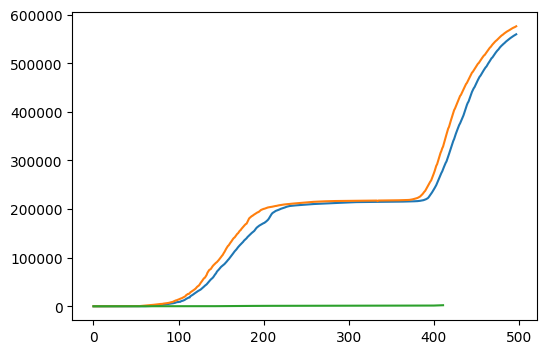

Jharkhand


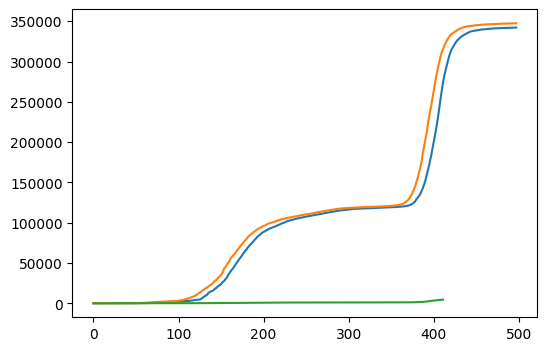

Arunachal Pradesh


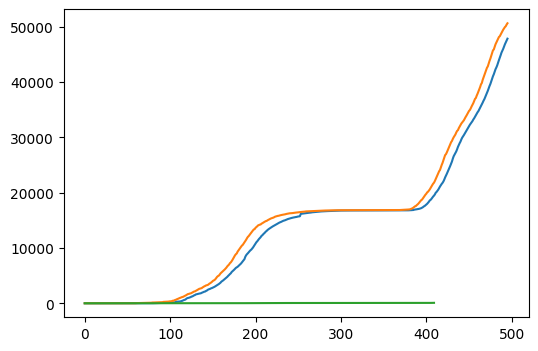

Tripura


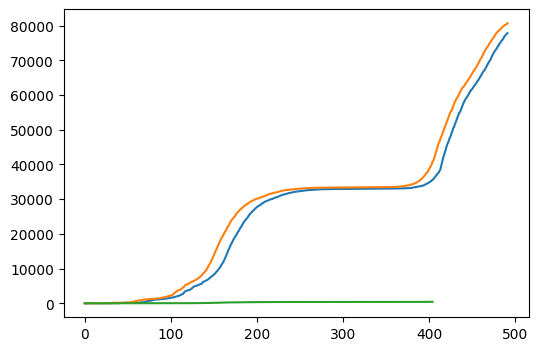

Nagaland


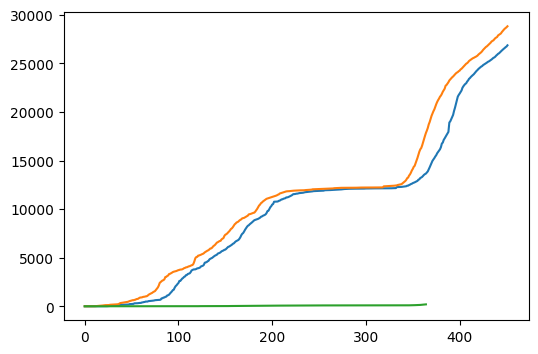

Meghalaya


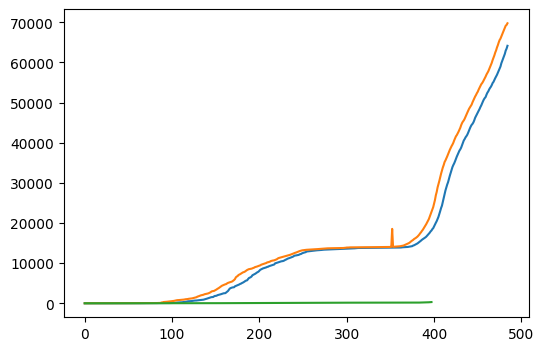

Dadra and Nagar Haveli and Daman and Diu


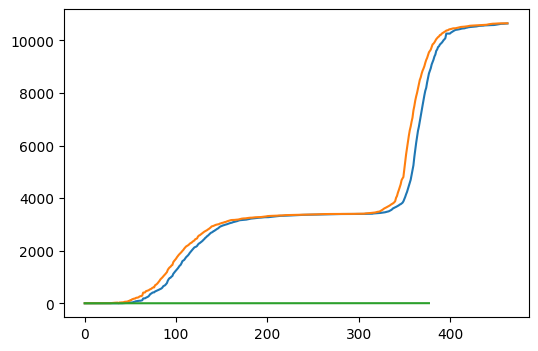

Sikkim


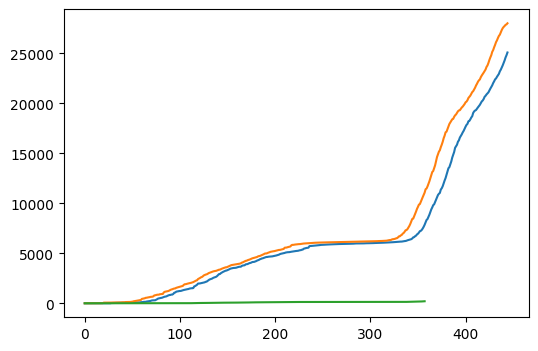

Lakshadweep


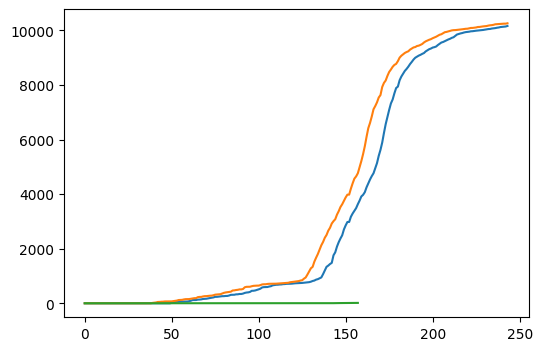

In [ ]:
# just to check the trend of cured, confirmed and predicted deaths
for i in Total_data_prime["State/UnionTerritory"].unique():
    print(i)
    plt.plot(Total_data_prime[Total_data_prime["State/UnionTerritory"]==i][["Cured", "Confirmed"]].values)
    plt.plot(data[data["State/UnionTerritory"]==i]["Deaths"].values)
    plt.show()